<a href="https://colab.research.google.com/github/hmbpps/taxfraude/blob/main/taxfraude.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Sentetik Veri Seti Oluşturma

This section generates a synthetic dataset with features relevant to tax non-compliance, such as turnover, profit margin, expenditure ratio, employee count, sector risk score, debts to partners ratio, accountant change count, and prior year non-compliance. It then defines rules to create the target variable 'Uyumsuzluk' (non-compliance) based on these features, simulating real-world scenarios.

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings('ignore') # Uyarıları gizlemek için

In [89]:
# --- 1. Sentetik Veri Seti Oluşturma ---
# Gerçek dünyadaki vergi mükelleflerinin özelliklerini yansıtmaya çalışıyoruz.

np.random.seed(1998) # Tekrar üretilebilir sonuçlar için

num_mükellef = 10000 # Mükellef sayısı

# Değişkenler (Özellikler):
# Gerçek vergi verilerindeki olası göstergeleri simüle ediyoruz.
data = {
    'Ciro': np.random.normal(loc=500000, scale=200000, size=num_mükellef).astype(int), # Yıllık Ciro
    'KarMarjiOrani': np.random.beta(a=2, b=5, size=num_mükellef) * 0.5, # Kar Marjı Oranı (0-0.5 arası)
    'HarcamaGorunumOrani': np.random.normal(loc=0.7, scale=0.15, size=num_mükellef), # Beyan Edilen Harcama / Ciro Oranı
    'CalisanSayisi': np.random.poisson(lam=10, size=num_mükellef), # Çalışan Sayısı
    'SektorRiskSkoru': np.random.randint(1, 10, size=num_mükellef), # Sektörün Vergi Riski Skoru (1:Düşük, 9:Yüksek)
    'OrtaklaraBorclarOrani': np.random.beta(a=1, b=8, size=num_mükellef) * 0.3, # Ortaklara Borçlar / Ciro Oranı
    'MuhasebeciDegisimSayisi': np.random.randint(0, 5, size=num_mükellef), # Son 5 Yılda Muhasebeci Değişim Sayısı
    'OncekiYilUyumsuzluk': np.random.choice([0, 1], size=num_mükellef, p=[0.85, 0.15]) # Önceki Yılda Uyumsuzluk Tespiti (Evet/Hayır)
}

df = pd.DataFrame(data)

### Oluşturulan Veri Setindeki Değişkenlerin Açıklaması

Sentetik veri setimiz (`df`) aşağıdaki değişkenleri (özellikleri) içermektedir:

*   **Ciro**: Mükellefin yıllık cirosunu temsil eder. Genellikle yüksek ciro, vergi denetimi için potansiyel risk teşkil edebilir, özellikle diğer faktörlerle birleştiğinde.

*   **KarMarjiOrani**: Mükellefin kar marjı oranını gösterir (Kar / Ciro). Beklenenden düşük kar marjları, vergi uyumsuzluğunun bir göstergesi olabilir.

*   **HarcamaGorunumOrani**: Mükellefin beyan ettiği harcamaların cirosuna oranını ifade eder. Aşırı yüksek harcama oranları şüpheli olabilir.

*   **CalisanSayisi**: Mükellefin çalışan sayısını belirtir. Çalışan sayısı ile ciro veya kar marjı arasındaki tutarsızlıklar dikkate değer olabilir.

*   **SektorRiskSkoru**: Mükellefin faaliyet gösterdiği sektörün vergi risk skorudur (1: Düşük risk, 9: Yüksek risk). Yüksek riskli sektörlerdeki mükellefler daha fazla denetime tabi olabilir.

*   **OrtaklaraBorclarOrani**: Mükellefin ortaklarına olan borçlarının cirosuna oranını gösterir. Bu oranın yüksek olması, finansal manipülasyon veya vergi kaçırma potansiyeli taşıyabilir.

*   **MuhasebeciDegisimSayisi**: Mükellefin son 5 yılda kaç kez muhasebeci değiştirdiğini ifade eder. Sık muhasebeci değişikliği, finansal kayıtları gizleme veya düzenleme çabalarının bir işareti olabilir.

*   **OncekiYilUyumsuzluk**: Mükellefin önceki yılda vergi uyumsuzluğu tespit edilip edilmediğini gösterir (0: Hayır, 1: Evet). Geçmişteki uyumsuzluklar, gelecekteki uyumsuzluk için güçlü bir göstergedir.

*   **Uyumsuzluk**: Bu, modelimizin tahmin etmeye çalıştığı hedef değişkendir (0: Uyumlu, 1: Uyumsuz). Bu değişken, yukarıdaki özelliklere dayalı olarak sentetik kurallarla oluşturulmuştur ve gerçek dünyadaki vergi uyumsuzluğunu simüle eder.

Bu değişkenler, vergi uyumsuzluğunu tahmin etmek ve riskli mükellefleri belirlemek için kullanılan temel göstergelerdir.

In [90]:
print("Veri Setindeki Değişkenler (Özellikler):")
display(df.head())

Veri Setindeki Değişkenler (Özellikler):


,Ciro,KarMarjiOrani,HarcamaGorunumOrani,CalisanSayisi,SektorRiskSkoru,OrtaklaraBorclarOrani,MuhasebeciDegisimSayisi,OncekiYilUyumsuzluk
0,807868,0.345618,0.769616,15,6,0.001014,0,0
1,569988,0.047577,0.807504,8,2,0.026611,0,0
2,657793,0.310060,0.775883,12,7,0.080267,0,0
3,351627,0.118562,0.848140,9,6,0.048069,0,0
4,731101,0.061109,0.836477,9,7,0.031005,2,0


In [91]:
df.describe()

,Ciro,KarMarjiOrani,HarcamaGorunumOrani,CalisanSayisi,SektorRiskSkoru,OrtaklaraBorclarOrani,MuhasebeciDegisimSayisi,OncekiYilUyumsuzluk
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.966704e+05,0.142089,0.701310,10.003100,5.041900,0.033451,1.991500,0.159900
std,1.992351e+05,0.079485,0.149298,3.189029,2.589713,0.029914,1.420503,0.366532
min,-2.145910e+05,0.000765,0.187790,0.000000,1.000000,0.000002,0.000000,0.000000
25%,3.615520e+05,0.080165,0.599404,8.000000,3.000000,0.010538,1.000000,0.000000
50%,4.985470e+05,0.131375,0.701921,10.000000,5.000000,0.024837,2.000000,0.000000
75%,6.295115e+05,0.193468,0.804523,12.000000,7.000000,0.048496,3.000000,0.000000
max,1.323037e+06,0.443352,1.322133,24.000000,9.000000,0.215501,4.000000,1.000000


In [92]:
# Ciro, Çalışan Sayısı vb. değerler negatif olmamalı
df['Ciro'] = df['Ciro'].apply(lambda x: max(10000, x))
df['KarMarjiOrani'] = df['KarMarjiOrani'].apply(lambda x: max(0.01, min(0.45, x)))
df['HarcamaGorunumOrani'] = df['HarcamaGorunumOrani'].apply(lambda x: max(0.1, min(0.9, x)))
df['CalisanSayisi'] = df['CalisanSayisi'].apply(lambda x: max(1, x))
df['OrtaklaraBorclarOrani'] = df['OrtaklaraBorclarOrani'].apply(lambda x: max(0.001, min(0.25, x)))


In [93]:
print("Veri Setindeki Değişkenler (Özellikler):")
display(df.head())

Veri Setindeki Değişkenler (Özellikler):


,Ciro,KarMarjiOrani,HarcamaGorunumOrani,CalisanSayisi,SektorRiskSkoru,OrtaklaraBorclarOrani,MuhasebeciDegisimSayisi,OncekiYilUyumsuzluk
0,807868,0.345618,0.769616,15,6,0.001014,0,0
1,569988,0.047577,0.807504,8,2,0.026611,0,0
2,657793,0.310060,0.775883,12,7,0.080267,0,0
3,351627,0.118562,0.848140,9,6,0.048069,0,0
4,731101,0.061109,0.836477,9,7,0.031005,2,0


In [94]:
df.describe()

,Ciro,KarMarjiOrani,HarcamaGorunumOrani,CalisanSayisi,SektorRiskSkoru,OrtaklaraBorclarOrani,MuhasebeciDegisimSayisi,OncekiYilUyumsuzluk
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.971360e+05,0.142109,0.695173,10.003200,5.041900,0.033464,1.991500,0.159900
std,1.979650e+05,0.079451,0.138046,3.188731,2.589713,0.029901,1.420503,0.366532
min,1.000000e+04,0.010000,0.187790,1.000000,1.000000,0.001000,0.000000,0.000000
25%,3.615520e+05,0.080165,0.599404,8.000000,3.000000,0.010538,1.000000,0.000000
50%,4.985470e+05,0.131375,0.701921,10.000000,5.000000,0.024837,2.000000,0.000000
75%,6.295115e+05,0.193468,0.804523,12.000000,7.000000,0.048496,3.000000,0.000000
max,1.323037e+06,0.443352,0.900000,24.000000,9.000000,0.215501,4.000000,1.000000


In [77]:
# --- Bağımlı Değişken Oluşturma: Vergi Uyumsuzluğu (Y) ---
# Gerçekçi bir "vergi uyumsuzluğu" mantığı kuruyoruz.
# Bazı değişkenlerin uyumsuzluk riskini artırdığını varsayıyoruz.
# Örneğin, yüksek riskli sektör, düşük kar marjına rağmen yüksek ciro, sık muhasebeci değişimi vb.

df['Uyumsuzluk'] = 0 # Varsayılan: kimse uyumsuz değil

# Uyumsuzluk yaratacak kurallar (sentetik ve mantıksal):
df.loc[(df['SektorRiskSkoru'] > 7) & (df['KarMarjiOrani'] < 0.05) & (df['Ciro'] > 700000), 'Uyumsuzluk'] = 1
df.loc[(df['HarcamaGorunumOrani'] > 0.85) & (df['Ciro'] > 1000000), 'Uyumsuzluk'] = 1 # Aşırı yüksek harcama beyanı
df.loc[(df['MuhasebeciDegisimSayisi'] >= 3) & (df['Ciro'] > 500000), 'Uyumsuzluk'] = 1
df.loc[(df['OrtaklaraBorclarOrani'] > 0.15) & (df['KarMarjiOrani'] < 0.1), 'Uyumsuzluk'] = 1
df.loc[(df['OncekiYilUyumsuzluk'] == 1), 'Uyumsuzluk'] = 1 # Önceki yıl uyumsuzluk varsa, bu yıl da yüksek ihtimalle uyumsuzluk

In [68]:
# Uyumsuz mükellef sayısını artırmak için rastgele eklemeler (gürültü)
num_fraudulent = df['Uyumsuzluk'].sum()
random_fraud_indices = np.random.choice(df[df['Uyumsuzluk'] == 0].index, size=int(num_mükellef * 0.05), replace=False)
df.loc[random_fraud_indices, 'Uyumsuzluk'] = 1

print(f"Toplam Mükellef Sayısı: {num_mükellef}")
print(f"Uyumsuz Mükellef Sayısı: {df['Uyumsuzluk'].sum()}")
print(f"Uyumsuzluk Oranı: {df['Uyumsuzluk'].mean():.2f}")

display(df.head())

Toplam Mükellef Sayısı: 10000
Uyumsuz Mükellef Sayısı: 3752
Uyumsuzluk Oranı: 0.38


,Ciro,KarMarjiOrani,HarcamaGorunumOrani,CalisanSayisi,SektorRiskSkoru,OrtaklaraBorclarOrani,MuhasebeciDegisimSayisi,OncekiYilUyumsuzluk,Uyumsuzluk
0,807868,0.345618,0.769616,15,6,0.001014,0,0,0
1,569988,0.047577,0.807504,8,2,0.026611,0,0,0
2,657793,0.310060,0.775883,12,7,0.080267,0,0,0
3,351627,0.118562,0.848140,9,6,0.048069,0,0,0
4,731101,0.061109,0.836477,9,7,0.031005,2,0,0


### 2. Veri Ön İşleme ve Ayırma

In this step, the dataset is prepared for machine learning models. Features (`X`) and the target variable (`y`) are separated. The data is then split into training and testing sets, ensuring a stratified split to maintain the proportion of non-compliant cases in both sets. Finally, numerical features are scaled using `StandardScaler` to normalize their ranges, which is crucial for certain models like Logistic Regression.

In [69]:
# --- 2. Veri Ön İşleme ve Ayırma ---

X = df.drop('Uyumsuzluk', axis=1)
y = df['Uyumsuzluk']

# Veriyi eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Özellik Ölçeklendirme (Standartlaştırma)
# Özellikle Lojistik Regresyon gibi modeller için önemlidir.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Ölçeklendirilmiş verileri DataFrame'e geri dönüştürme (daha kolay görselleştirme ve yorumlama için)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("X_train_scaled_df head:")
display(X_train_scaled_df.head())
print("X_test_scaled_df head:")
display(X_test_scaled_df.head())

X_train_scaled_df head:


,Ciro,KarMarjiOrani,HarcamaGorunumOrani,CalisanSayisi,SektorRiskSkoru,OrtaklaraBorclarOrani,MuhasebeciDegisimSayisi,OncekiYilUyumsuzluk
0,-1.416173,-0.375984,0.621610,2.195521,1.531091,-0.843260,-1.404273,-0.439216
1,0.261669,-0.998217,-0.357036,-0.320115,-1.552566,0.250925,-1.404273,-0.439216
2,-0.363392,-0.588638,-0.060945,0.623249,-1.552566,1.833771,0.005640,-0.439216
3,-1.310298,3.095623,1.485128,0.623249,-0.010738,-0.545969,1.415552,-0.439216
4,-0.009723,0.951828,0.008175,-1.263478,0.760176,-0.475318,-1.404273,-0.439216


X_test_scaled_df head:


,Ciro,KarMarjiOrani,HarcamaGorunumOrani,CalisanSayisi,SektorRiskSkoru,OrtaklaraBorclarOrani,MuhasebeciDegisimSayisi,OncekiYilUyumsuzluk
0,-1.656633,-0.270856,0.956631,1.252158,-1.167109,-0.117298,-1.404273,-0.439216
1,-0.215899,-0.954755,-1.313411,-0.949024,1.531091,1.100305,-1.404273,-0.439216
2,-0.967975,0.385832,-0.474787,0.308794,-0.396195,-1.078956,0.005640,-0.439216
3,-0.794656,2.812119,-1.297763,1.252158,-0.396195,0.017316,0.005640,-0.439216
4,2.170355,-0.681371,-1.632772,1.566612,-1.552566,3.475989,0.005640,-0.439216


### 3. Modelleri Oluşturma ve Eğitme

Here, three different classification models are initialized and trained:

*   **Logistic Regression**: A classic linear model often used as a baseline.
*   **Random Forest**: An ensemble method that builds multiple decision trees and merges their predictions. The `class_weight='balanced'` parameter helps handle imbalanced datasets.
*   **XGBoost**: A powerful gradient boosting framework. `scale_pos_weight` is used to address class imbalance.

In [70]:
# --- 3. Model Oluşturma ve Eğitme ---

# Lojistik Regresyon (Klasik ve Karşılaştırma İçin)
log_reg = LogisticRegression(solver='liblinear', random_state=42)
log_reg.fit(X_train_scaled, y_train)
y_pred_log_reg = log_reg.predict(X_test_scaled)
y_prob_log_reg = log_reg.predict_proba(X_test_scaled)[:, 1] # Olasılıkları al

# Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced') # class_weight dengesiz veri için iyidir
rf_clf.fit(X_train, y_train) # Random Forest ölçeklendirilmiş veriye ihtiyaç duymaz
y_pred_rf = rf_clf.predict(X_test)
y_prob_rf = rf_clf.predict_proba(X_test)[:, 1]

# XGBoost
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, scale_pos_weight=(len(y_train) - y_train.sum()) / y_train.sum()) # scale_pos_weight dengesiz veri için iyidir
xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)
y_prob_xgb = xgb_clf.predict_proba(X_test)[:, 1]

print("Modeller başarıyla eğitildi.")

Modeller başarıyla eğitildi.


### 4. Model Performansını Değerlendirme ve Raporlama

This section defines a function `evaluate_model` to assess the performance of each trained model. For each model, it will print:

*   A classification report (precision, recall, f1-score, support).
*   A confusion matrix (True Positives, False Positives, True Negatives, False Negatives).
*   The Area Under the Receiver Operating Characteristic curve (AUC score), which indicates the model's ability to distinguish between classes.
*   A plot of the ROC curve for visual inspection.


--- Model Performans Raporları ---

Model: Lojistik Regresyon
Sınıflandırma Raporu:
               precision    recall  f1-score   support

           0       0.87      0.94      0.91      1874
           1       0.89      0.77      0.83      1126

    accuracy                           0.88      3000
   macro avg       0.88      0.86      0.87      3000
weighted avg       0.88      0.88      0.88      3000

Karmaşıklık Matrisi (Confusion Matrix):
 [[1768  106]
 [ 258  868]]
AUC Skoru: 0.92


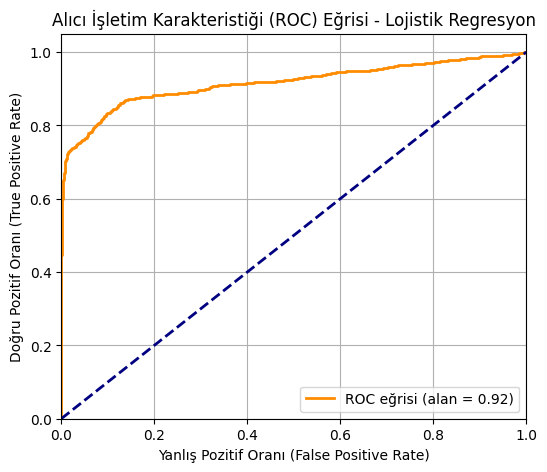


Model: Random Forest
Sınıflandırma Raporu:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96      1874
           1       1.00      0.86      0.92      1126

    accuracy                           0.95      3000
   macro avg       0.96      0.93      0.94      3000
weighted avg       0.95      0.95      0.94      3000

Karmaşıklık Matrisi (Confusion Matrix):
 [[1874    0]
 [ 163  963]]
AUC Skoru: 0.93


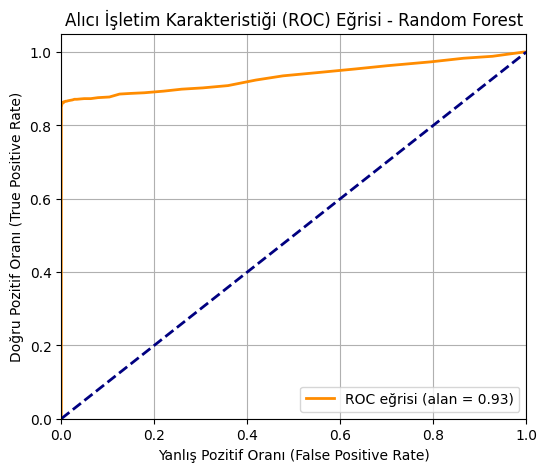


Model: XGBoost
Sınıflandırma Raporu:
               precision    recall  f1-score   support

           0       0.92      0.99      0.95      1874
           1       0.98      0.86      0.92      1126

    accuracy                           0.94      3000
   macro avg       0.95      0.92      0.93      3000
weighted avg       0.94      0.94      0.94      3000

Karmaşıklık Matrisi (Confusion Matrix):
 [[1851   23]
 [ 156  970]]
AUC Skoru: 0.93


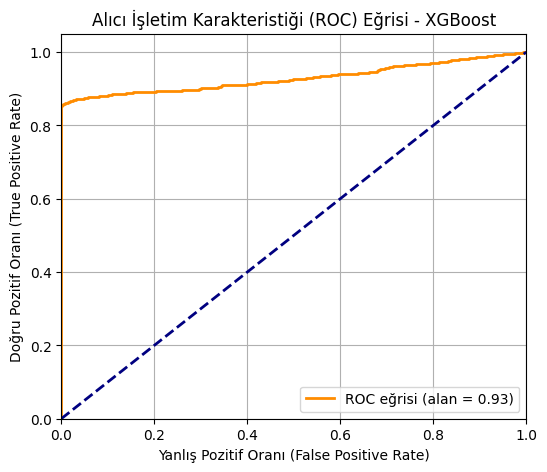

In [71]:
# --- 4. Model Performansını Değerlendirme ve Raporlama ---

print("\n--- Model Performans Raporları ---")

def evaluate_model(name, y_true, y_pred, y_prob):
    print(f"\nModel: {name}")
    print("Sınıflandırma Raporu:\n", classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    print("Karmaşıklık Matrisi (Confusion Matrix):\n", cm)

    # ROC Eğrisi ve AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    print(f"AUC Skoru: {roc_auc:.2f}")

    # ROC Eğrisini Çizme
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC eğrisi (alan = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Yanlış Pozitif Oranı (False Positive Rate)')
    plt.ylabel('Doğru Pozitif Oranı (True Positive Rate)')
    plt.title(f'Alıcı İşletim Karakteristiği (ROC) Eğrisi - {name}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# Her model için değerlendirme
evaluate_model("Lojistik Regresyon", y_test, y_pred_log_reg, y_prob_log_reg)
evaluate_model("Random Forest", y_test, y_pred_rf, y_prob_rf)
evaluate_model("XGBoost", y_test, y_pred_xgb, y_prob_xgb)

### 5. Önemli Özellikleri Görselleştirme (Feature Importance)

This step visualizes the importance of each feature in the Random Forest and XGBoost models. Feature importance scores indicate which input variables contribute most significantly to the model's predictions. This helps in understanding the underlying factors driving tax non-compliance.


--- Özellik Önem Sırası (Feature Importance) ---


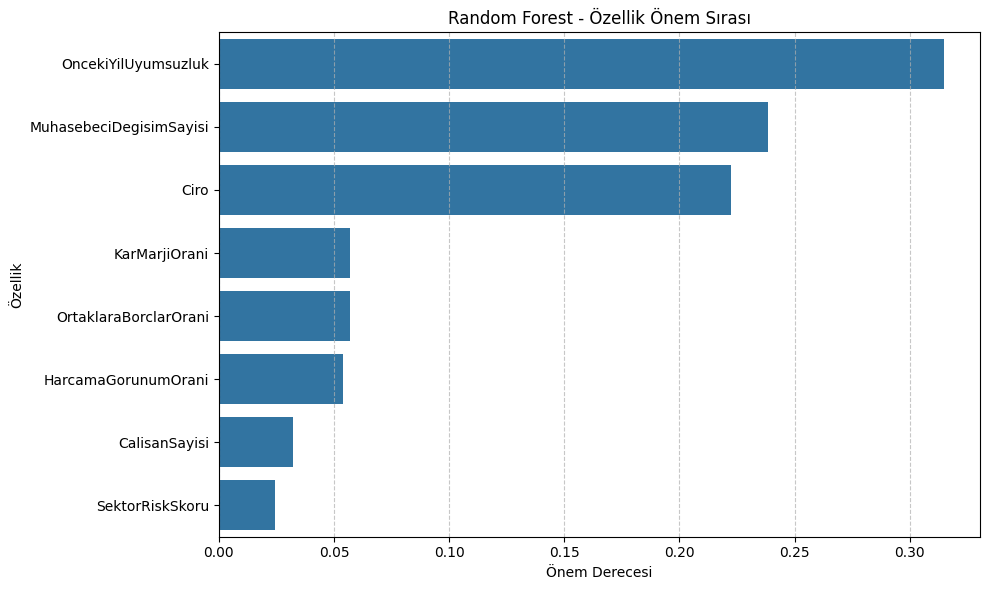

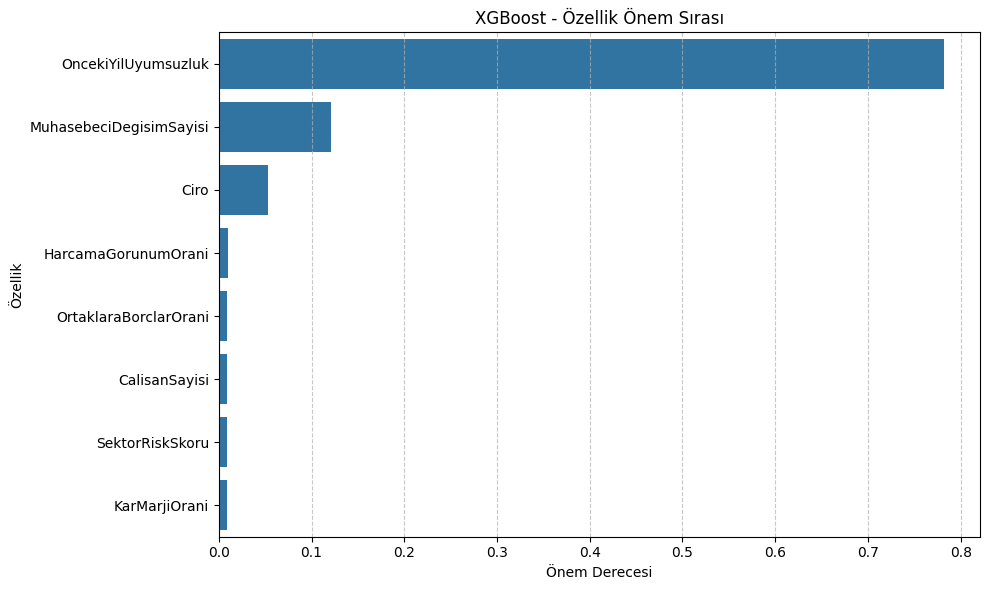

In [72]:
# --- 5. Özellik Önem Sırası Görselleştirme (Feature Importance) ---
# Random Forest ve XGBoost, hangi özelliklerin model tahminlerine en çok katkı sağladığını gösterir.

print("\n--- Özellik Önem Sırası (Feature Importance) ---")

# Random Forest
feature_importances_rf = pd.Series(rf_clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances_rf.values, y=feature_importances_rf.index)
plt.title('Random Forest - Özellik Önem Sırası')
plt.xlabel('Önem Derecesi')
plt.ylabel('Özellik')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# XGBoost
feature_importances_xgb = pd.Series(xgb_clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances_xgb.values, y=feature_importances_xgb.index)
plt.title('XGBoost - Özellik Önem Sırası')
plt.xlabel('Önem Derecesi')
plt.ylabel('Özellik')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### 6. Bulguların Yorumlanması ve Politika Önerileri İçin Notlar

This final section provides a textual interpretation of the model results and suggests potential policy recommendations based on the findings. It highlights key metrics like ROC AUC, F1-Score, and the importance of understanding the confusion matrix to minimize false negatives (missed non-compliant taxpayers) while managing false positives (incorrectly flagged compliant taxpayers).

In [73]:
# --- 6. Bulguların Yorumlanması ve Politika Önerileri İçin Notlar ---

print("\n--- Bulguları Yorumlama ve Politika Önerileri İçin Notlar ---")
print("1. ROC AUC skoru, modelin uyumsuz ve uyumlu mükellefleri ne kadar iyi ayırdığını gösterir.")
print("   Değer 1'e ne kadar yakınsa o kadar iyidir.")
print("2. F1-Score, özellikle dengesiz veri setlerinde (az sayıda uyumsuz mükellef) önemli bir metriktir.")
print("3. Özellik Önem Sırası grafikleri, hangi mükellef özelliklerinin (Ciro, Kar Marjı, Sektör Riski vb.)")
print("   vergi uyumsuzluğunu tahmin etmede daha etkili olduğunu gösterir.")
print("4. Karmaşıklık Matrisi (Confusion Matrix), modelin doğru ve yanlış tahminlerini detaylandırır.")
print("   - Gerçek Pozitifler (TP): Doğru tespit edilen uyumsuz mükellefler.")
print("   - Yanlış Pozitifler (FP): Hatalı olarak uyumsuz zannedilen dürüst mükellefler (maliyetli olabilir).")
print("   - Gerçek Negatifler (TN): Doğru tespit edilen dürüst mükellefler.")
print("   - Yanlış Negatifler (FN): Gözden kaçan uyumsuz mükellefler (vergi kaybı).")
print("\nPolitika Önerisi Örneği:")
print("  - Eğer 'SektorRiskSkoru' ve 'KarMarjiOrani' en önemli özelliklerse, Maliye Bakanlığı bu alanlara odaklanarak")
print("    riskli sektörlerdeki düşük kâr marjlı yüksek cirolu firmaları daha detaylı inceleyebilir.")
print("  - Modellerin 'Yanlış Pozitif' oranları, denetim kaynaklarının boşa harcanma riskini gösterir.")
print("  - 'Yanlış Negatif' oranları ise, gözden kaçan potansiyel vergi kaçaklarını ifade eder.")
print("  - Amaç, FN'yi minimize ederken FP'yi kabul edilebilir bir seviyede tutmaktır.")
print("\nBu sentetik verilerle elde edilen sonuçlar, gerçek dünya verileriyle benzer eğilimler gösterebilir.")
print("Makalenizde bu modelin nasıl bir 'risk skorlama' aracı olarak kullanılabileceğini vurgulamalısınız.")


--- Bulguları Yorumlama ve Politika Önerileri İçin Notlar ---
1. ROC AUC skoru, modelin uyumsuz ve uyumlu mükellefleri ne kadar iyi ayırdığını gösterir.
   Değer 1'e ne kadar yakınsa o kadar iyidir.
2. F1-Score, özellikle dengesiz veri setlerinde (az sayıda uyumsuz mükellef) önemli bir metriktir.
3. Özellik Önem Sırası grafikleri, hangi mükellef özelliklerinin (Ciro, Kar Marjı, Sektör Riski vb.)
   vergi uyumsuzluğunu tahmin etmede daha etkili olduğunu gösterir.
4. Karmaşıklık Matrisi (Confusion Matrix), modelin doğru ve yanlış tahminlerini detaylandırır.
   - Gerçek Pozitifler (TP): Doğru tespit edilen uyumsuz mükellefler.
   - Yanlış Pozitifler (FP): Hatalı olarak uyumsuz zannedilen dürüst mükellefler (maliyetli olabilir).
   - Gerçek Negatifler (TN): Doğru tespit edilen dürüst mükellefler.
   - Yanlış Negatifler (FN): Gözden kaçan uyumsuz mükellefler (vergi kaybı).

Politika Önerisi Örneği:
  - Eğer 'SektorRiskSkoru' ve 'KarMarjiOrani' en önemli özelliklerse, Maliye Bakanlığı bu al